# agential learning using active inference

#### prerequisites

In [1]:
# !pip install inferactively-pymdp # the sparse-likelilihoods_111 branch was used here
import os
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import pymdp
from pymdp import utils 
from pymdp import maths
from pymdp.agent import Agent

In [2]:
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

In [3]:
def plot_all_choices_beliefs(choice_self_hist, belief_self_context_hist, expcondition_hist, outcome_hist, pad_val=1.0):
    
    print(f'Experimental Condition (or Context): {env.expcondition}')
    
    T = choice_self_hist.shape[1]
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15,7))
    
    axes[0].imshow(belief_self_context_hist, cmap = 'gray')
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(num_states[0]))
    axes[0].set_yticklabels(labels = self_context_names)
    axes[0].set_title('Beliefs about control the self has over time')

    axes[1].imshow(choice_self_hist[:,:-1], cmap = 'gray') 
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(num_states[1]))
    axes[1].set_yticklabels(labels = self_action_names)
    axes[1].set_title('Actions produced by the self over time')

    axes[2].imshow(outcome_hist[:,:-1], cmap = 'gray') 
    axes[2].set_xlabel('Timesteps')
    axes[2].set_yticks(ticks = range(num_obs[0]))
    axes[2].set_yticklabels(labels = obs_outcome_names)
    axes[2].set_title('Outcomes observed over time')

    fig.tight_layout(pad=pad_val)
    plt.show()

### THE GENERATIVE MODEL

#### specifying the states and observations

In [4]:
""" Defining state factors """
self_context_names = ['self_positivecontrol', 'self_negativecontrol', 'self_zerocontrol']
self_action_names = ['self_buttonpress', 'self_buttonnotpress']

""" Defining number of state factors and states """
num_states = [len(self_context_names), len(self_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_self_context_names = ['no_changes']
choice_self_action_names = ['self_pressbutton', 'self_notpressbutton']

""" Defining number of control states """
num_controls = [len(choice_self_context_names), len(choice_self_action_names)]

""" Defining observational modalities """
obs_outcome_names = ['outcome_present', 'outcome_absent']
obs_choice_self_names = ['self_buttonpress', 'self_buttonnotpress']

""" Defining number of observational modalities and observations """
num_obs = [len(obs_outcome_names), len(obs_choice_self_names)]
num_modalities = len(num_obs)

#### likelihood (A) tensors

In [5]:
def create_A(p_outcome):
    
    A_gp = utils.obj_array(num_modalities)
    
    ''' A matrix for outcome '''
    
    A_outcome = np.zeros( (len(obs_outcome_names), len(self_context_names), len(self_action_names)) )
    
    # SELF_POS
    
    # p(outcome | self_pos, self_press)
    #                    present       absent
    A_outcome[:,0,0] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_pos, self_notpress)
    #                    present       absent
    A_outcome[:,0,1] = [1.0-p_outcome, p_outcome]
    
    
    # SELF_NEG
    
    # p(outcome | self_neg, self_press)
    #                    present       absent
    A_outcome[:,1,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_neg, self_notpress)
    #                    present       absent
    A_outcome[:,1,1] = [p_outcome, 1.0-p_outcome]
    
    
    # SELF_ZERO
    
    # p(outcome | self_zero, self_press)
    #                   pre  abs
    A_outcome[:,2,0] = [0.5, 0.5]
    
    # p(outcome | self_zero, self_notpress)
    #                   pre  abs
    A_outcome[:,2,1] = [0.5, 0.5]

    ''' A matrix for proprioception '''
    A_choice_self = np.zeros((len(obs_choice_self_names), len(self_action_names)))
    
    A_choice_self = np.eye(len(self_action_names))
    
    
    ''' stacking up the A matrices '''
    A_gp[0], A_gp[1] = A_outcome, A_choice_self
    A_factor_list = [[0,1], [1]]
    
    A_gp = utils.norm_dist_obj_arr(A_gp)
    
    pA = utils.dirichlet_like(A_gp, scale = 1.0)

    pA[0] = pA[0] / np.sum(pA[0])

    A = utils.norm_dist_obj_arr(pA) 
    
    return A, A_factor_list, pA

controllable_indices = [1]
learnable_modalities = [0]

#### state transition (B) tensors

In [6]:
def create_B():
    
    B = utils.initialize_empty_B(num_states, num_states)
    
    ''' B matrix for context regarding the self '''
    B_self_context = np.zeros( (len(self_context_names), len(self_context_names), len(choice_self_context_names)) )
    B_self_context[:,:,0] = np.eye(len(self_context_names))
    
    ''' B matrix for actions the self can make '''
    B_self_choice = np.zeros( (len(self_action_names), len(self_action_names), len(choice_self_action_names)) )
    
    for choice_id in range(len(self_action_names)):
        B_self_choice[choice_id, :, choice_id] = 1.0
    
    ''' stacking up the B matrices '''
    B[0], B[1] = B_self_context, B_self_choice
    
    B = utils.norm_dist_obj_arr(B)
    
    return B

#### preferences (C) vectors

In [7]:
def create_C(outcomepref, actionpref, noactionpref):
        
    C = utils.obj_array_zeros(num_obs)
    C[0] = np.array([outcomepref, 0.0])
    C[1] = np.array([actionpref, noactionpref])
    
    return C

#### priors (D) vectors

In [8]:
def create_D():
    
    D = utils.obj_array(num_factors)
    
    D_self_context = np.ones(num_states[0])/float(num_states[0])
    
    D_self_choice = np.zeros(len(self_action_names)) 
    D_self_choice = np.ones(num_states[1])/float(num_states[1])

    D[0], D[1] = D_self_context, D_self_choice
    
    return D

### THE GENERATIVE PROCESS

In [9]:
class AgencyTask(object):
    
    def __init__(self, expcondition = None , p_other_action = 0.5, p_outcome = 1.0):
        
        # defining the experimental conditions for the generative process
#         self.expcondition_names = ['s_pos_o_zer', 's_neg_o_zer',
#                                    's_zer_o_pos', 's_zer_o_neg', 
#                                    's_zer_o_zer']
        
        self.expcondition_names = ['s_pos', 's_neg', 's_zer']
        
        self.num_expcondition = len(self.expcondition_names)
        
        if expcondition == None:
            self.expcondition = self.expcondition_names[utils.sample(np.ones(self.num_expcondition)/self.num_expcondition)] # randomly sample which context is selected
        else:
            self.expcondition = expcondition
            
        self.p_outcome = p_outcome
        
        self.obs_outcome_names = ['outcome_present', 'outcome_absent']
                
    def step(self, action):

        # defining what happens in the generative process: what observations are presented to the agent given certain states (actions and context)
        if action == "self_pressbutton":
            observed_choice_self = "self_buttonpress"
            
            if self.expcondition == 's_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.5, 0.5]))]
            
        elif action == "self_notpressbutton":
            observed_choice_self = "self_buttonnotpress"
            
            if self.expcondition == 's_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.5, 0.5]))]
            
        obs = [observed_outcome, observed_choice_self]

        return obs

### RUNNING ACTIVE INFERENCE 

In [10]:
def run_active_inference_loop(my_agent, my_env, T, verbose):

    choice_self_hist = np.zeros((num_controls[1],T))
    
    belief_self_context_hist = np.zeros((num_states[0], T))
    belief_self_action_hist = np.zeros((num_states[1], T))
    
    expcondition_hist = np.zeros(T)
    outcome_hist = np.zeros((num_obs[0],T))
    
    pA_hist = []
    
    for t in range(T):
        
        q_pi, efe = my_agent.infer_policies_factorized()
        
        chosen_action_id = my_agent.sample_action()
        action_id = int(chosen_action_id[1])
        choice_self_hist[action_id,t]= 1.0
        choice_action = choice_self_action_names[action_id]
        
        obs_label = my_env.step(choice_action)
        obs = [obs_outcome_names.index(obs_label[0]), obs_choice_self_names.index(obs_label[1])]
        
        expcondition_hist[t] = env.expcondition_names.index(env.expcondition)
        
        qs = my_agent.infer_states(obs)
        belief_self_context_hist[:,t] = qs[0]
        belief_self_action_hist[:,t] = qs[1]
        
        outcome_hist[obs[0],t] = 1.0
        
        pA_t = my_agent.update_A(obs)
        pA_hist.append(pA_t)
            
    return choice_self_hist, belief_self_context_hist, expcondition_hist, outcome_hist, pA_hist

In [11]:
p_outcome_env = 1.0

env = AgencyTask(p_outcome = p_outcome_env)

T = 50

A,A_factor_list,pA = create_A(p_outcome = 0.6)
B = create_B()
C = create_C(outcomepref = 5.0, actionpref = 0.0, noactionpref = 0.05)
D = create_D()
my_agent = Agent(A=A, B=B, C=C, D=D, A_factor_list=A_factor_list,
                 pA=pA, control_fac_idx=controllable_indices,
                 modalities_to_learn=learnable_modalities,
                 lr_pA=0.25, use_param_info_gain=True)


choice_self_hist, belief_self_context_hist, expcondition_hist, outcome_hist, pA_hist = run_active_inference_loop(my_agent, env, T = T, verbose = False)

### PLOTTING 

In [12]:
# plot_some_choices_beliefs(choice_hist, belief_hist, context_hist)

Experimental Condition (or Context): s_pos


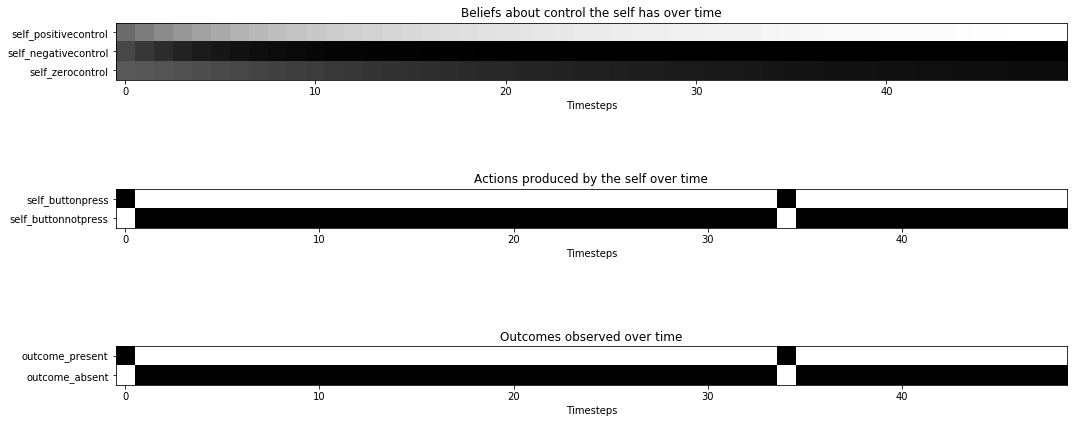

In [13]:
plot_all_choices_beliefs(choice_self_hist, belief_self_context_hist, expcondition_hist, outcome_hist)